In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

In [2]:
from run_functions import *
from agent_functions import *
from plot_functions import *

In [12]:
from routing_networks import *
# from recommenders import *

In [4]:
def heuristic_recommender(Q, n_agents):
    S = np.zeros(n_agents)
    flexible = []
    force_up = []
    force_down = []
    force_cross = []
    arg_max_Q = np.argmax(Q, axis=2)

    for i, argmax_q_table in enumerate(arg_max_Q):
        if 0 in argmax_q_table:  # could the agent go up?
            if 1 in argmax_q_table: # could the agent go down?
                flexible.append(i)  # if both, store for later assignment
#                 print(i, "flexible", argmax_q_table)
            else:
                force_up.append(i)  # if only up, assign agent to go up
#                 print(i, "up", argmax_q_table)
        elif 1 in argmax_q_table:
                force_down.append(i) # if only down, assign agent to go down
#                 print(i, "down", argmax_q_table)
        else:
            force_cross.append(i) # add logic for sure crossers
#             print(i, "cross", argmax_q_table)
    
#     print("force up", force_up)
#     print("force down", force_down)
#     print("force cross", force_cross)
#     print("flexible", flexible)
    
    n_flexible = len(flexible)
    n_up = len(force_up)
    n_down = len(force_down)
    n_cross = len(force_cross)
    
#     print(n_up, n_down, n_cross, n_flexible)
#     print("flexible \n", flexible)
    diff_up_down = n_up - n_down
    
    if abs(diff_up_down) >= n_flexible:
        if diff_up_down > 0:
            # assign all flexible to down
            while len(flexible) > 0: force_down.append(flexible.pop())
        else:
            # assign all flexible to up
            while len(flexible) > 0: force_up.append(flexible.pop())
                
    elif abs(diff_up_down) < n_flexible:
        if diff_up_down > 0:
            # assign #diff_up_down flexible to down
            for x in range(abs(diff_up_down)): force_down.append(flexible.pop())
        else:
            # assign #diff_up_down flexible to up
            for x in range(abs(diff_up_down)): force_up.append(flexible.pop())
                
        # split remaining flexible up and down equally
        counter = 0
        while len(flexible) > 0:
            if counter%2 == 0:
                force_down.append(flexible.pop())
            else:
                force_up.append(flexible.pop())
            counter += 1
    
#     print("force up", force_up)
#     print("force down", force_down)
#     print("force cross", force_cross)
#     print("flexible", flexible)
    
    travel_time_estimate = [
        1+(1-n_cross/n_agents)/2+n_cross/n_agents,  # up 
        1+(1-n_cross/n_agents)/2+n_cross/n_agents,  # down
        1+n_cross/n_agents                          # cross
    ]
    
    for i in force_up:
        recommendations_that_force = np.argwhere(arg_max_Q[i]==0).flatten()
#         print(recommendations_that_force)
        belief_differences = - travel_time_estimate[0] - Q[i, recommendations_that_force, 0]
#         if len(belief_differences) == 0:
#             print(i, " has len 0")
        best_recommendation = np.argmax(belief_differences)
#         print(best_recommendation)
        S[i] = recommendations_that_force[best_recommendation]
    
    for i in force_down:
        recommendations_that_force = np.argwhere(arg_max_Q[i]==1).flatten()
        belief_differences = - travel_time_estimate[1] - Q[i, recommendations_that_force, 1]
        best_recommendation = np.argmax(belief_differences)
        S[i] = recommendations_that_force[best_recommendation]
    
    for i in force_cross:
        recommendations_that_force = np.argwhere(arg_max_Q[i]==2).flatten()
        belief_differences = - travel_time_estimate[2] - Q[i, recommendations_that_force, 2]
        best_recommendation = np.argmin(belief_differences)
        S[i] = recommendations_that_force[best_recommendation]
        
    return S.astype(int)

In [20]:
Q = initialize_q_table("UNIFORM", 4, 3, 3)

In [25]:
Q.shape

(4, 3, 3)

In [35]:
S = np.zeros(4)
flexible = []
force_up = []
force_down = []
force_cross = []
arg_max_Q = np.argmax(Q, axis=2)
alignment_table = arg_max_Q[:,:2] == np.broadcast_to(np.arange(2), (4, 2))  # alignment of up and down, only
print(alignment_table)

[[ True False]
 [False False]
 [False  True]
 [False  True]]


### Testing Braess Recommenders

In [39]:
N_AGENTS = 100
N_STATES = 3
N_ACTIONS = 3
N_ITER = 1000

EPSILON = 0.01
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.1

QINIT = "ALIGNED"  # np.array([-2, -2, -2])

In [40]:
%%time
Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M = {}
ind = np.arange(N_AGENTS)
S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)

for t in range(N_ITER):
    
#     S = recommender(Q=Q, initial_guess=A, n_actions=N_ACTIONS, objective=objective)
    S = heuristic_recommender(Q, N_AGENTS)
#     print(Q)
    A = e_greedy_select_action(Q, S, EPSILON)

    R, travel_time_per_route = braess_augmented_network(A)

    Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)
    
    ## SAVE PROGRESS DATA
    M[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            "groups": count_groups(Q[ind, S, :], 0.1),
            "Qvar": Q[ind, S, :].var(axis=0),
            "nA": np.bincount(A, minlength=3),
            "T": travel_time_per_route,
            "sum_of_belief_updates": sum_of_belief_updates,
            "alignment": calculate_alignment(Q)
           }

CPU times: user 2.43 s, sys: 17.2 ms, total: 2.45 s
Wall time: 2.45 s


In [43]:
alignment = np.array([M[t]["alignment"] for t in range(int(0.8 * N_ITER), N_ITER)])
alignment = alignment.mean(axis=0)

In [44]:
alignment

array([0.98895, 0.9719 , 1.     ])

test2


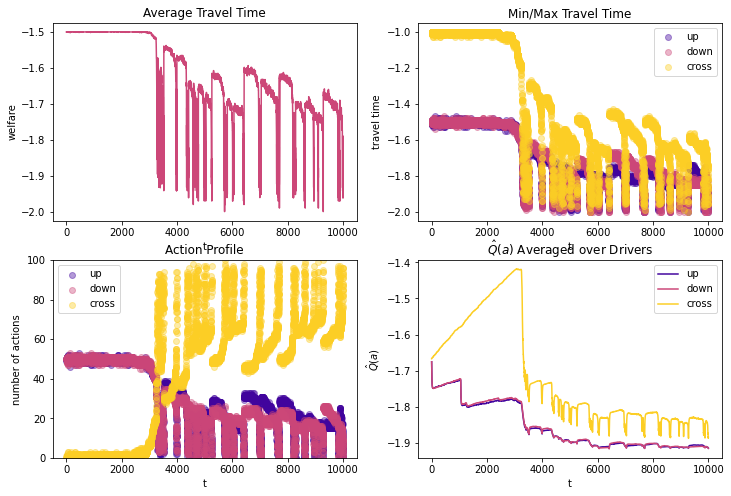

In [9]:
plot_run(M, "test2", N_AGENTS, N_ACTIONS, N_ITER)

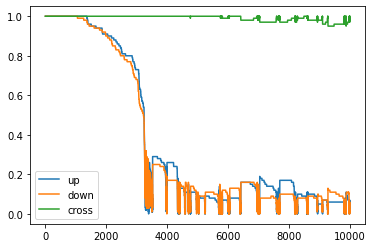

In [10]:
plt.plot([M[t]["alignment"] for t in range(N_ITER)], label=["up", "down", "cross"])
plt.legend()

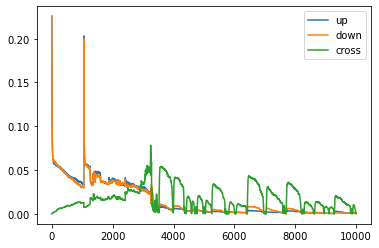

In [15]:
plt.plot([M[t]["Qvar"] for t in range(N_ITER)], label=["up", "down", "cross"])
plt.legend()

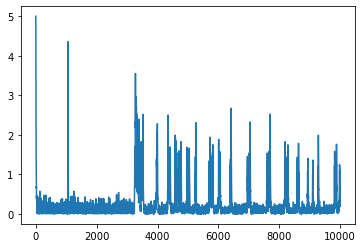

In [11]:
plt.plot([M[t]["sum_of_belief_updates"] for t in range(N_ITER)])

In [ ]:
plot_run(M, "test", N_AGENTS, N_ACTIONS, N_ITER)

## Two Route Game

In [ ]:
def two_route_game(A):
    n_agents = len(A)
    n_up = (A == 0).sum()
    
    r_0 = n_up/n_agents
    r_1 = 1
    T = [-r_0, -r_1]

    R = np.array([T[i] for i in A])
    return R, T

In [ ]:
N_AGENTS = 100
N_STATES = 2
N_ACTIONS = 2
N_ITER = 1000

EPSILON = 0.01
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.25

QINIT = - np.random.random_sample((N_AGENTS, N_STATES, N_ACTIONS))  # "UNIFORM"  # np.array([-2, -2, -2])
objective = total_welfare

In [ ]:
Q = InitializeQTable(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M = {}

S = np.random.randint(N_STATES, size=N_AGENTS)
# R = np.ones(N_AGENTS) * -1
A = np.random.randint(N_STATES, size=N_AGENTS)

for t in range(N_ITER):
    
    S = recommender(Q=Q, initial_guess=A, n_actions=N_ACTIONS, objective=objective)
    
    A = e_greedy_select_action(Q, S, EPSILON)

    R, travel_time_per_route = two_route_game(A)

    Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)

    ## SAVE PROGRESS DATA
    M[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            # "groups": count_groups(Q[ind, S, :], 0.1),
            # "Qvar": Q[ind, S, :].var(axis=0),
            "nA": np.bincount(A, minlength=3),
            "T": travel_time_per_route,
           }

# Live Recommender Tool (needs sudo)

In [3]:
import keyboard

In [5]:
N_AGENTS = 100
N_STATES = 3
N_ACTIONS = 3
N_ITER = 20000

EPSILON = 0.1
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.25

QINIT = "UNIFORM"  # np.array([-2, -2, -2])

In [6]:
Q = InitializeQTable(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M = {}

S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)

NameError: name 'InitializeQTable' is not defined

In [ ]:
# %matplotlib widget

fig = plt.figure(figsize=(10,8))
hfig = display(fig, display_id=True)
recommender_on = False

on_timesteps = []
off_timesteps = []

for t in range(N_ITER):
    if keyboard.is_pressed("r"):
        recommender_on = True
        on_timesteps.append(t)
        S = heuristic_recommender(Q, N_AGENTS)
    elif keyboard.is_pressed("e"):
        recommender_on = False
        off_timesteps.append(t)
        S = S
    
#     S = recommender_next_state(R, Q, S, A, recommender_on)
    
    A = e_greedy_select_action(Q, S, EPSILON)

    R, _ = braess_augmented_network(A)

    Q, _ = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)

    ## SAVE PROGRESS DATA
    M[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            # "groups": count_groups(Q[ind, S, :], 0.1),
            # "Qvar": Q[ind, S, :].var(axis=0)
           }
    
    plt.clf()
    plt.plot(np.arange(0, t, 1), [M[i]["R"].mean() for i in range(t)])
#     plt.plot(on_timesteps, [M[i]["R"].mean() for i in on_timesteps])
#     plt.plot(off_timesteps, [M[i]["R"].mean() for i in off_timesteps])
#     ax2.hist(np.bincount(S))
    fig.canvas.draw()
    hfig.update(fig)
    time.sleep(0.1)
    